In [32]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.22631-SP0


In [33]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './archive'

In [17]:
pip install imgaug

  Obtaining dependency information for imgaug from https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for Shapely from https://files.pythonhosted.org/packages/29/cd/763817c27e6cb6d04ffd477a5dcdfdd71bc3fb640f5748c9f2c1cd08ba52/shapely-2.0.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   - ------------------------------------- 30.7/948.0 kB 660.6 kB/s eta 0:00:02
   -- ------------------------------------ 61.4/948.0 kB 656.4 kB/s eta 0:00:02
   -------- ------------------------------- 194.6/948.0 kB 1.5 MB/s eta 0:00:01
   ----------------- ---------------------- 409.6/948.0 kB 2.3 MB/s eta 0:00:01
   --------------------------- ------------ 645.1/948.0 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------  942.1

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [35]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [36]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Shoplifting videos \n{} Normal videos'.format(
              len(os.listdir(VideoDataDir + '/Shoplifting')), 
              len(os.listdir(VideoDataDir + '/Normal'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["Normal", "Shoplifting"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
89 Shoplifting videos 
86 Normal videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████████████████████████████████| 89/89 [01:20<00:00,  1.11it/s]

CPU times: total: 2min 13s
Wall time: 2min 29s


In [37]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

8348

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [39]:
!pip install imutils
clear_output()

In [17]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [40]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Dropout, Flatten, Dense

import matplotlib.pyplot as plt

In [41]:
epochs = 40

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_

 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 16, 16, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_d

 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 8, 8, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
          

 block_9_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 8, 8, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 8, 8, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
          

 block_13_expand_BN (BatchN  (None, 8, 8, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 9, 9, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 4, 4, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D

                                                                                                  
 block_16_depthwise (Depthw  (None, 4, 4, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 4, 4, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_

In [42]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [23]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [43]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/40
1461/1461 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.5059
Epoch 1: val_loss did not improve from 0.15453
1461/1461 [==============================] - 143s 95ms/step - loss: 0.8992 - accuracy: 0.5059 - val_loss: 0.7864 - val_accuracy: 0.5086 - lr: 1.0000e-05
Epoch 2/40
1461/1461 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.5383
Epoch 2: val_loss did not improve from 0.15453
1461/1461 [==============================] - 99s 68ms/step - loss: 0.7388 - accuracy: 0.5383 - val_loss: 0.7112 - val_accuracy: 0.5645 - lr: 1.8000e-05
Epoch 3/40
1461/1461 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.6129
Epoch 3: val_loss did not improve from 0.15453
1461/1461 [==============================] - 92s 63ms/step - loss: 0.6631 - accuracy: 0.6129 - val_loss: 0.6400 - val_accuracy: 0.6363 - lr: 2.6000e-05
Epoch 4/40
1461/1461 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 

1461/1461 [==============================] - 86s 59ms/step - loss: 0.3923 - accuracy: 0.8287 - val_loss: 0.4288 - val_accuracy: 0.8032 - lr: 1.0295e-05
Epoch 29/40
1461/1461 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8301
Epoch 29: val_loss did not improve from 0.15453
1461/1461 [==============================] - 85s 58ms/step - loss: 0.3909 - accuracy: 0.8301 - val_loss: 0.4274 - val_accuracy: 0.8028 - lr: 1.0236e-05
Epoch 30/40
1461/1461 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8294
Epoch 30: val_loss did not improve from 0.15453
1461/1461 [==============================] - 85s 58ms/step - loss: 0.3894 - accuracy: 0.8294 - val_loss: 0.4264 - val_accuracy: 0.8036 - lr: 1.0189e-05
Epoch 31/40
1460/1461 [============================>.] - ETA: 0s - loss: 0.3881 - accuracy: 0.8295
Epoch 31: val_loss did not improve from 0.15453
1461/1461 [==============================] - 84s 58ms/step - loss: 0.3880 - accuracy: 0.8295 - val_loss

In [46]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)                

In [47]:
model_summary(model, history)

------------------------------------------------------------------------------------------
Best Epochs:  None


TypeError: list indices must be integers or slices, not NoneType

## **Evaluation on test set**

In [48]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
79/79 [==============================] - 16s 179ms/step


C:\Users\hp\AppData\Local\Temp/ipykernel_6244/3180812836.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
C:\Users\hp\AppData\Local\Temp/ipykernel_6244/3180812836.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

> Correct Predictions: 4606
> Wrong Predictions: 203


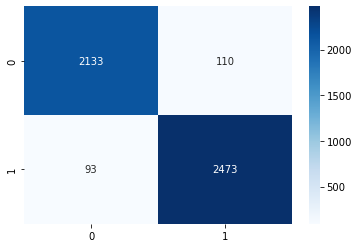

              precision    recall  f1-score   support

 NonViolence       0.96      0.95      0.95      2243
    Violence       0.96      0.96      0.96      2566

    accuracy                           0.96      4809
   macro avg       0.96      0.96      0.96      4809
weighted avg       0.96      0.96      0.96      4809



In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [49]:
args_model = "modelshoplift.h5"
model.save(args_model)

C:\Users\Ajithabh Krishna\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
